# 数据预处理

In [1]:
import h5py
import numpy as np
import tensorflow as tf 
import keras
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, Conv1D, MaxPooling2D, concatenate, BatchNormalization
from keras.models import Model
import matplotlib.pyplot as plt
%matplotlib inline

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

with h5py.File('./data/DB1_S1_image.h5.bak', 'r') as f:
    imageData = f['imageData'][:]
    imageLabel = f['imageLabel'][:]

# 随机打乱数据和标签
N = imageData.shape[0]
index = np.random.permutation(N)
data = imageData[index, :, :]
label = imageLabel[index]

# 对数据升维 标签one-hot
data = np.expand_dims(data, axis=2)
label = convert_to_one_hot(label, 52).T

# 划分数据集
N = data.shape[0]
num_train = round(N*0.8)
X_train = data[0:num_train, :, :]
Y_train = label[0:num_train, :]
X_test = data[num_train:N, :, :]
Y_test = label[num_train:N, :]

print('X_train shape:', str(X_train.shape))
print('Y_train shape:', str(Y_train.shape))
print('X_test shape:', str(X_test.shape))
print('Y_test shape:', str(Y_test.shape))

X_train shape: (12038, 12, 1, 10)
Y_train shape: (12038, 52)
X_test shape: (3009, 12, 1, 10)
Y_test shape: (3009, 52)


In [19]:
# 写一个LossHistory类 保存loss和acc
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc='upper right')
        plt.show()

# 建立模型

In [3]:
def CNN(input_shape=(12, 1, 10), classes=52): 
    X_input = Input(input_shape)
    X = Conv2D(filters=32, kernel_size=(6, 1), strides=(1, 1), padding='same', activation='relu', name='conv1')(X_input)
    X = Conv2D(filters=64, kernel_size=(4, 1), strides=(1, 1), padding='same', activation='relu', name='conv2')(X)
    X = MaxPooling2D(pool_size=(2, 1), strides=(2, 1), name='pool1')(X)
    X = Conv2D(filters=128, kernel_size=(2, 1),strides=(1,1), padding='same', activation='relu', name='conv3')(X)
    X = MaxPooling2D(pool_size=(2, 1), strides=(2, 1), name='pool2')(X)
    X = Flatten(name='flatten')(X)
    X = Dropout(0.5)(X)
    X = Dense(128,activation='relu', name='fc1')(X)
    X = Dropout(0.5)(X)
    X = Dense(classes, activation='softmax', name='fc2')(X)
    model = Model(inputs=X_input, outputs=X, name='CNN')
    return model

model = CNN(input_shape=(12, 1, 10), classes=52)
model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12, 1, 10)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 12, 1, 32)         1952      
_________________________________________________________________
conv2 (Conv2D)               (None, 12, 1, 64)         8256      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 6, 1, 64)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 6, 1, 128)         16512     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 3, 1, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 384)               0       

# 训练原始数据

In [17]:
import time
start = time.time()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = LossHistory() # 创建一个history实例

model.fit(X_train, Y_train, epochs=200, batch_size=64, verbose=1,
            validation_data=(X_test, Y_test), callbacks=[history])

preds_train = model.evaluate(X_train, Y_train)
print('Train Loss =', str(preds_train[0]))
print('Train Accuracy =', str(preds_train[1]))

preds_test  = model.evaluate(X_test, Y_test)
print('Test Loss =', str(preds_test[0]))
print('Test Accuracy =', str(preds_test[1]))

end = time.time()
print('time:', end - start)

Epoch 1/200
189/189 [==============================] - 2s 8ms/step - loss: 0.6774 - acc: 0.7795 - val_loss: 0.9659 - val_acc: 0.7521
Epoch 2/200
189/189 [==============================] - 1s 6ms/step - loss: 0.6629 - acc: 0.7814 - val_loss: 0.9623 - val_acc: 0.7511
Epoch 3/200
189/189 [==============================] - 1s 7ms/step - loss: 0.6655 - acc: 0.7813 - val_loss: 0.9503 - val_acc: 0.7461
Epoch 4/200
189/189 [==============================] - 2s 9ms/step - loss: 0.6662 - acc: 0.7853 - val_loss: 0.9339 - val_acc: 0.7471
Epoch 5/200
189/189 [==============================] - 1s 7ms/step - loss: 0.6750 - acc: 0.7767 - val_loss: 0.9294 - val_acc: 0.7481
Epoch 6/200
189/189 [==============================] - 1s 7ms/step - loss: 0.6915 - acc: 0.7768 - val_loss: 0.9458 - val_acc: 0.7411
Epoch 7/200
189/189 [==============================] - 1s 6ms/step - loss: 0.6784 - acc: 0.7809 - val_loss: 0.9731 - val_acc: 0.7394
Epoch 8/200
189/189 [==============================] - 2s 9ms/step - 

Epoch 62/200
189/189 [==============================] - 3s 18ms/step - loss: 0.6352 - acc: 0.7918 - val_loss: 0.9703 - val_acc: 0.7478
Epoch 63/200
189/189 [==============================] - 3s 16ms/step - loss: 0.6332 - acc: 0.7883 - val_loss: 0.9537 - val_acc: 0.7524
Epoch 64/200
189/189 [==============================] - 3s 18ms/step - loss: 0.6226 - acc: 0.7954 - val_loss: 0.9451 - val_acc: 0.7517
Epoch 65/200
189/189 [==============================] - 3s 18ms/step - loss: 0.6257 - acc: 0.7922 - val_loss: 0.9656 - val_acc: 0.7488
Epoch 66/200
189/189 [==============================] - 3s 15ms/step - loss: 0.6382 - acc: 0.7943 - val_loss: 0.9294 - val_acc: 0.7471
Epoch 67/200
189/189 [==============================] - 3s 15ms/step - loss: 0.6067 - acc: 0.7968 - val_loss: 0.9657 - val_acc: 0.7524
Epoch 68/200
189/189 [==============================] - 3s 17ms/step - loss: 0.6343 - acc: 0.7899 - val_loss: 0.9632 - val_acc: 0.7501
Epoch 69/200
189/189 [==============================] -

189/189 [==============================] - 2s 10ms/step - loss: 0.6072 - acc: 0.8024 - val_loss: 0.9498 - val_acc: 0.7474
Epoch 123/200
189/189 [==============================] - 2s 9ms/step - loss: 0.6070 - acc: 0.8005 - val_loss: 0.9576 - val_acc: 0.7514
Epoch 124/200
189/189 [==============================] - 2s 11ms/step - loss: 0.6027 - acc: 0.8011 - val_loss: 0.9379 - val_acc: 0.7478
Epoch 125/200
189/189 [==============================] - 2s 10ms/step - loss: 0.6077 - acc: 0.8025 - val_loss: 0.9829 - val_acc: 0.7458
Epoch 126/200
189/189 [==============================] - 2s 9ms/step - loss: 0.6122 - acc: 0.8003 - val_loss: 0.9777 - val_acc: 0.7421
Epoch 127/200
189/189 [==============================] - 2s 9ms/step - loss: 0.6188 - acc: 0.8002 - val_loss: 0.9909 - val_acc: 0.7488
Epoch 128/200
189/189 [==============================] - 2s 9ms/step - loss: 0.6044 - acc: 0.8014 - val_loss: 0.9909 - val_acc: 0.7461
Epoch 129/200
189/189 [==============================] - 2s 10ms/s

189/189 [==============================] - 4s 19ms/step - loss: 0.5610 - acc: 0.8093 - val_loss: 1.0374 - val_acc: 0.7498
Epoch 183/200
189/189 [==============================] - 4s 20ms/step - loss: 0.5658 - acc: 0.8123 - val_loss: 0.9928 - val_acc: 0.7511
Epoch 184/200
189/189 [==============================] - 4s 21ms/step - loss: 0.5827 - acc: 0.8083 - val_loss: 1.0108 - val_acc: 0.7544
Epoch 185/200
189/189 [==============================] - 3s 17ms/step - loss: 0.5829 - acc: 0.8070 - val_loss: 0.9859 - val_acc: 0.7514
Epoch 186/200
189/189 [==============================] - 3s 14ms/step - loss: 0.5850 - acc: 0.8101 - val_loss: 0.9912 - val_acc: 0.7537
Epoch 187/200
189/189 [==============================] - 3s 15ms/step - loss: 0.5910 - acc: 0.8037 - val_loss: 1.0125 - val_acc: 0.7441
Epoch 188/200
189/189 [==============================] - 3s 15ms/step - loss: 0.5617 - acc: 0.8143 - val_loss: 0.9665 - val_acc: 0.7534
Epoch 189/200
189/189 [==============================] - 3s 14

{'batch': [0.4462708532810211, 0.5966347455978394, 0.654442310333252, 0.6676560640335083, 0.7342829704284668, 0.7333694100379944, 0.7333493828773499, 0.7190018892288208, 0.7147641777992249, 0.7042064070701599, 0.7131168842315674, 0.6925753951072693, 0.67195063829422, 0.6690569519996643, 0.6599494814872742, 0.6744905114173889, 0.684649646282196, 0.694085955619812, 0.6820095181465149, 0.6776538491249084, 0.6765443086624146, 0.6744279861450195, 0.6724810004234314, 0.6708560585975647, 0.6733691692352295, 0.6730406284332275, 0.6664116382598877, 0.6658336520195007, 0.6635810136795044, 0.6641199588775635, 0.6705257296562195, 0.6804782748222351, 0.6836196780204773, 0.6900050044059753, 0.6933539509773254, 0.6951479315757751, 0.6923326849937439, 0.6886722445487976, 0.6813857555389404, 0.6833060383796692, 0.6912192702293396, 0.6977816820144653, 0.6936886310577393, 0.690341591835022, 0.6907011270523071, 0.6908825635910034, 0.6929208636283875, 0.6982192397117615, 0.699763298034668, 0.70289826393127

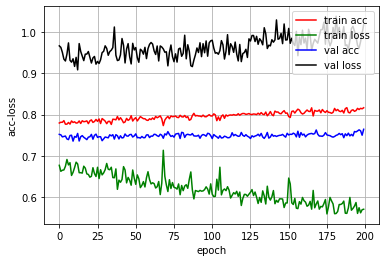

In [18]:
history.loss_plot('epoch')